In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import s1etad
from s1etad import Sentinel1Etad, ECorrectionType

In [5]:
filename = '../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE'

In [6]:
correction_type = ECorrectionType.SUM
direction = 'x'
meter = True

etad = Sentinel1Etad(filename)
merged_correction = etad.merge_correction(correction_type, meter=meter)

# masked arrays
data = merged_correction[direction]
lat = merged_correction['lats']
lon = merged_correction['lons']
height = merged_correction['height']

In [7]:
from osgeo import gdal, osr

In [8]:
def _write_band_data(band, data, nodata: float = -9999.):
    if hasattr(data, 'filled'):
        data = data.filled(nodata)        
    band.WriteArray(data)
    band.SetNoDataValue(nodata)

In [9]:
import functools


MAX_GCP_NUM = 10000


def create_gcps(lat, lon, h=None, gcp_step = (10, 10)):    
    assert lat.shape == lon.shape
    ysize, xsize = lat.shape
    ystep, xstep = gcp_step

    masks = [
        data.mask if hasattr(data, 'mask') else None for data in (lat, lon, h)
    ]
    if masks:
        mask = functools.reduce(np.logical_or, masks)
    else:
        mask = None

    gcps = []
    for line in range(0, ysize, ystep):
        for pix in range(0, xsize, xstep):
            if mask is None or mask[line, pix]:
                continue
            height = h[line, pix] if h is not None else 0.
            gcp_info = ''
            gcp_id = f'len(gcps)'
            gcp = gdal.GCP(lon[line, pix], lat[line, pix], height,
                           pix, line, gcp_info, gcp_id)
            gcps.append(gcp)
    
    assert 0 < len(gcps) <= MAX_GCP_NUM
    
    return gcps

def save_with_gcps(outfile: str, data, lat, lon, h=None,
                   *, drv_name: str = 'GTIFF', nodata: float = -9999.,
                   gcp_step = (10, 10), srs='wgs84', create_options=None):
    drv = gdal.GetDriverByName(drv_name)
    assert drv is not None
    
    ysize, xsize = data.shape    
    if create_options is None:
        create_options = []
    ds = drv.Create(str(outfile), xsize=xsize, ysize=ysize,
                    bands=1, eType=gdal.GDT_Float32,
                    options=create_options)

    if isinstance(srs, str):
        srs_str = srs
        srs = osr.SpatialReference()
        srs.SetWellKnownGeogCS(srs_str)
    gcps = create_gcps(lat, lon, h, gcp_step)
    ds.SetGCPs(gcps, srs)

    _write_band_data(ds.GetRasterBand(1), data, nodata)    
    
    return ds

In [10]:
ysize, xsize = data.shape
gcp_step = (25, 25)  # 5 x 5 km
# gcp_step = (50, 50)  # 10 x 10 km
# gcp_step = (100, 100)  # 20 x 20 km
while (ysize // gcp_step[0]) * (xsize // gcp_step[1]) > MAX_GCP_NUM:
    # increase the step only in the azimuth direction
    gcp_step = (gcp_step[0]*2, gcp_step[1])
print('gcp_step', gcp_step)

ds1 = save_with_gcps('', data, lat=lat, lon=lon, h=height, gcp_step=gcp_step, drv_name='MEM')

gcp_step (100, 25)


In [11]:
srs = 'wgs84'
res = 0.005  # deg --> 550m equator, 50 @ lat=85deg
bbox = (lon.min(), lat.min(), lon.max(), lat.max())
def clip_bbox(bbox, q, margin=0):
    return (
        np.floor(bbox[0] / q) * q - margin * q,
        np.floor(bbox[1] / q) * q - margin * q,
        np.ceil(bbox[2] / q) * q + margin * q,
        np.ceil(bbox[3] / q) * q + margin * q,
    )
bbox = clip_bbox(bbox, res, margin=50)

ds2 = gdal.Warp('', ds1,
               format='MEM',
               dstSRS=srs,
               xRes=res,
               yRes=res,
               targetAlignedPixels=True,
               outputBounds=bbox,
               outputBoundsSRS=srs)
ds2.FlushCache()

In [12]:
ds3 = gdal.Translate('', ds2,
                     format='MEM',
                     outputType=gdal.GDT_Byte,
                     noData=0,
                     scaleParams=[[data.min(), data.max(), 0, 255]])

In [13]:
from matplotlib import cm
from s1etad.kmz import Colorizer

colorizer = Colorizer(0, 255, color_table=cm.jet)

band = ds3.GetRasterBand(1)
band.SetRasterColorTable(colorizer.gdal_palette())
band.SetRasterColorInterpretation(gdal.GCI_PaletteIndex)
band.FlushCache()
band = None
ds3.FlushCache()

In [14]:
outfile = 'geocoded_ql.png'
ds4 = gdal.Translate(outfile, ds3, format='PNG',
                     creationOptions='WORLDFILE=YES')

In [15]:
# ds1 = None
# ds2 = None
# ds3 = None
# ds4 = None

In [16]:
img = ds3.ReadAsArray()

In [17]:
img.min(), img.max(), img.dtype

(0, 255, dtype('uint8'))

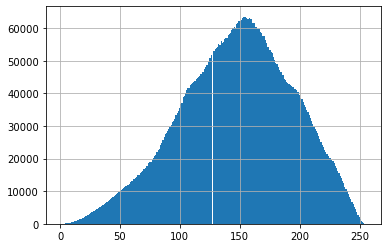

In [18]:
mask = (img != 0)
flatdata = img[mask]

plt.hist(flatdata.ravel(), 256);
plt.grid()

In [19]:
print(flatdata.dtype)
flatdata.min(), flatdata.max(), flatdata.std(), np.quantile(flatdata, [0.01, 0.99])

uint8


(1, 255, 46.83585373445911, array([ 35., 239.]))

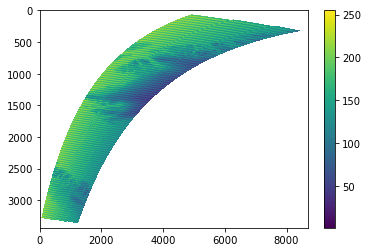

In [20]:
ma_img = np.ma.masked_array(img, np.logical_not(mask))
plt.imshow(ma_img, aspect='auto')  #, vmin=2.15, vmax=3.74)
plt.colorbar()
# plt.axis(False)
# plt.gcf().savefig('ql.png', dpi=200)

In [21]:
print(gdal.Info(ds4, showColorTable=False))

Driver: PNG/Portable Network Graphics
Files: geocoded_ql.png
       geocoded_ql.wld
Size is 8682, 3434
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-79.384999999999991,84.995000000000005)
Pixel Size = (0.005000000000000,-0.005000000000000)
Corner Coordinates:
Upper Left  ( -79.3850000,  84.9950000) ( 79d23' 6.00"W, 84d59'42.00"N)
Lower Left  ( -79.3850000,  67.8250000) ( 79d23' 6.00"W, 67d49'30.00"N)
Upper Right ( -35.9750000,  84.9950000) ( 35d58'30.00"W, 84d59'42.00